# Sistemas Cognitivos Artificiales - Laboratorio 3
## Integrantes del grupo:

- Sergio Manuel 

# Laboratorio: Modelos del lenguaje con RNNs

En este laboratorio, vamos a entrenar un modelo del lenguaje basado en caracteres con Recurrent Neural Networks. Asimismo, utilizaremos el modelo para generar texto. En particular, alimentaremos nuestro modelo con obras de la literatura clásica en castellano para obtener una red neuronal que sea capaz de "escribir" fragmentos literarios.

Los entrenamientos en esta laboratorio para obtener un modelo de calidad podrían tomar cierto tiempo (5-10 minutos por epoch), por lo que se aconseja empezar a trabajar pronto. El uso de GPUs no ayuda tanto con LSTMs como con CNNs, por lo que si tenéis máquinas potentes en casa es posible que podáis entrenar más rápido o a la misma velocidad que en Colab. En todo caso, la potencia de Colab es más que suficiente para completar este laboratorio con éxito.

<center><img src="https://upload.wikimedia.org/wikipedia/commons/d/d8/El_ingenioso_hidalgo_don_Quijote_de_la_Mancha.jpg" style="text-align: center" height="300px"></center>

El dataset a utilizar consistirá en un archivo de texto con el contenido íntegro en castellano antiguo de El Ingenioso Hidalgo Don Quijote de la Mancha, disponible de manera libre en la página de [Project Gutenberg](https://www.gutenberg.org). Asimismo, como apartado optativo en este laboratorio se pueden utilizar otras fuentes de texto. Aquí podéis descargar los datos a utilizar de El Quijote y un par de obras adicionales:

[El ingenioso hidalgo Don Quijote de la Mancha (Miguel de Cervantes)](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219424&authkey=AH0gb-qSo5Xd7Io)

[Compilación de obras teatrales (Calderón de la Barca)](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219433&authkey=AKvGD6DC3IRBqmc)

[Trafalgar (Benito Pérez Galdós)](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219434&authkey=AErPCAtMKOI5tYQ)

Como ya deberíamos de estar acostumbrados en problemas de Machine Learning, es importante echar un vistazo a los datos antes de empezar.

## 1. Carga y procesado del texto

Primero, vamos a descargar el libro e inspeccionar los datos. El fichero a descargar es una versión en .txt del libro de Don Quijote, a la cual se le han borrado introducciones, licencias y otras secciones para dejarlo con el contenido real de la novela.

In [1]:
import numpy as np 
import keras
import matplotlib.pyplot as plt
from keras.callbacks import LambdaCallback
from keras.models import Sequential

from keras.models import Model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Input


import random
import io

import os, sys

Using TensorFlow backend.


In [2]:
# Bajamos los archivos
path = keras.utils.get_file(
    fname="don_quijote.txt", 
    origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219424&authkey=AH0gb-qSo5Xd7Io"
)

path = keras.utils.get_file(
    fname="Trafalgar.txt", 
    origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219434&authkey=AErPCAtMKOI5tYQ"
)

Una vez descargado, vamos a leer el contenido del fichero en una variable. Adicionalmente, convertiremos el contenido del texto a minúsculas para ponérselo un poco más fácil a nuestro modelo (de modo que todas las letras sean minúsculas y el modelo no necesite diferenciar entre minúsculas y mayúsculas).

**1.1.** Leer todo el contenido del fichero en una única variable ***text*** y convertir el string a minúsculas

In [3]:
if os.name == 'nt':
    file_path = os.path.join(os.path.expanduser('~') + r'\.keras\datasets', 'don_quijote.txt')
else:
    file_path = os.path.join(os.path.expanduser('~') + '/.keras/datasets', 'don_quijote.txt')
    
with open(file_path, 'r', encoding='utf-8') as f:
    text = f.read()

# convierto a minúsculas
text = text.lower()

Podemos comprobar ahora que efectivamente nuestra variable contiene el resultado deseado, con el comienzo tan característico del Quijote.

In [4]:
print("Longitud del texto: {}".format(len(text)))
print(text[0:300])

Longitud del texto: 2071198
capítulo primero. que trata de la condición y ejercicio del famoso hidalgo
don quijote de la mancha


en un lugar de la mancha, de cuyo nombre no quiero acordarme, no ha mucho
tiempo que vivía un hidalgo de los de lanza en astillero, adarga antigua,
rocín flaco y galgo corredor. una olla de algo más


## 2. Procesado de los datos

Una de las grandes ventajas de trabajar con modelos que utilizan caracteres en vez de palabras es que no necesitamos tokenizar el texto (partirlo palabra a palabra). Nuestro modelo funcionará directamente con los caracteres en el texto, incluyendo espacios, saltos de línea, etc.

Antes de hacer nada, necesitamos procesar el texto en entradas y salidas compatibles con nuestro modelo. Como sabemos, un modelo del lenguaje con RNNs acepta una serie de caracteres y predice el siguiente carácter en la secuencia.

* "*El ingenioso don Qui*" -> predicción: **j**
* "*El ingenioso don Quij*" -> predicción: **o**

De modo que la entrada y la salida de nuestro modelo necesita ser algo parecido a este esquema. En este punto, podríamos usar dos formas de preparar los datos para nuestro modelo.

1. **Secuencia a secuencia**. La entrada de nuestro modelo sería una secuencia y la salida sería esa secuencia trasladada un caracter a la derecha, de modo que en cada instante de tiempo la RNN tiene que predecir el carácter siguiente. Por ejemplo:

>* *Input*:   El ingenioso don Quijot 
>* *Output*: l ingenioso don Quijote

2. **Secuencia a carácter**. En este variante, pasaríamos una secuencia de caracteres por nuestra RNN y, al llegar al final de la secuencia, predeciríamos el siguiente carácter.

>* *Input*:   El ingenioso don Quijot 
>* *Output*: e

En este laboratorio, por simplicidad, vamos a utilizar la segunda variante.

De este modo, a partir del texto, hemos de generar nuestro propio training data que consista en secuencias de caracteres con el siguiente carácter a predecir. Para estandarizar las cosas, utilizaremos secuencias de tamaño *SEQ_LENGTH* caracteres (un hiperparámetro que podemos elegir nosotros).



#### 2.1. Obtención de los caracteres y mapas de caracteres

Antes que nada, necesitamos saber qué caracteres aparecen en el texto, ya que tendremos que diferenciarlos mediante un índice de 0 a *num_chars* - 1 en el modelo. Obtener:
 

1.   Número de caracteres únicos que aparecen en el texto.
2.   Diccionario que asocia char a índice único entre 0 y *num_chars* - 1. Por ejemplo, {'a': 0, 'b': 1, ...}
3.   Diccionario reverso de índices a caracteres: {0: 'a', 1: 'b', ...}


In [5]:
# Busco los caracteres:
caracter_v = []
for c in text:
    if c not in caracter_v:
        caracter_v.append(c)
caracter_v.sort()

print(' - Se encontraron {:d} caracteres: {}'.format(len(caracter_v), caracter_v) )


# Armamos los diccionarios correspondientes.
idx_v = list(range(len(caracter_v)))
chr2idx_d = dict(zip(caracter_v, idx_v))
idx2chr_d = dict(zip(idx_v, caracter_v))

print(' - chr2idx_d = ', chr2idx_d)
print(' - idx2chr_d = ', idx2chr_d)

 - Se encontraron 61 caracteres: ['\n', ' ', '!', '"', "'", '(', ')', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', ':', ';', '?', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '¡', '«', '»', '¿', 'à', 'á', 'é', 'í', 'ï', 'ñ', 'ó', 'ù', 'ú', 'ü']
 - chr2idx_d =  {'\n': 0, ' ': 1, '!': 2, '"': 3, "'": 4, '(': 5, ')': 6, ',': 7, '-': 8, '.': 9, '0': 10, '1': 11, '2': 12, '3': 13, '4': 14, '5': 15, '6': 16, '7': 17, ':': 18, ';': 19, '?': 20, ']': 21, 'a': 22, 'b': 23, 'c': 24, 'd': 25, 'e': 26, 'f': 27, 'g': 28, 'h': 29, 'i': 30, 'j': 31, 'l': 32, 'm': 33, 'n': 34, 'o': 35, 'p': 36, 'q': 37, 'r': 38, 's': 39, 't': 40, 'u': 41, 'v': 42, 'w': 43, 'x': 44, 'y': 45, 'z': 46, '¡': 47, '«': 48, '»': 49, '¿': 50, 'à': 51, 'á': 52, 'é': 53, 'í': 54, 'ï': 55, 'ñ': 56, 'ó': 57, 'ù': 58, 'ú': 59, 'ü': 60}
 - idx2chr_d =  {0: '\n', 1: ' ', 2: '!', 3: '"', 4: "'", 5: '(', 6: ')', 7: ',', 8: '-', 9: '.', 10: '

#### 2.2. Obtención de secuencias de entrada y carácter a predecir

Ahora, vamos a obtener las secuencias de entrada en formato texto y los correspondientes caracteres a predecir. Para ello, recorrer el texto completo leído anteriormente, obteniendo una secuencia de SEQ_LENGTH caracteres y el siguiente caracter a predecir. Una vez hecho, desplazarse un carácter a la izquierda y hacer lo mismo para obtener una nueva secuencia y predicción. Guardar las secuencias en una variable ***sequences*** y los caracteres a predecir en una variable ***next_chars***.

Por ejemplo, si el texto fuera "Don Quijote" y SEQ_LENGTH fuese 5, tendríamos

* *sequences* = ["Don Q", "on Qu", "n Qui", " Quij", "Quijo", "uijot"]
* *next_chars* = ['u', 'i', 'j', 'o', 't', 'e']

In [5]:
# Definimos el tamaño de las secuencias. Puedes dejar este valor por defecto.
SEQ_LENGTH = 30

sequences = []
next_chars = []

for i in range(0, len(text) - SEQ_LENGTH - 1):
    sequences.append(  text[i:i+SEQ_LENGTH] )
    next_chars.append( text[i+SEQ_LENGTH]   )
    
assert len(sequences) == len(next_chars), 'ERROR, armaste mal las sequencias'

Indicar el tamaño del training set que acabamos de generar.

In [6]:
print(' Cantidad de secuencias armadas = ', len(sequences))

 Cantidad de secuencias armadas =  2071167


Como el Quijote es muy largo y tenemos muchas secuencias, podríamos encontrar problemas de memoria. Por ello, vamos a elegir un número máximo de ellas. Si estás corriendo esto localmente y tienes problemas de memoria, puedes reducir el tamaño aún más, pero ten cuidado porque, a menos datos, peor calidad del modelo.

In [7]:
MAX_SEQUENCES = 500000

perm = np.random.permutation(len(sequences))
sequences, next_chars = np.array(sequences), np.array(next_chars)
sequences, next_chars = sequences[perm], next_chars[perm]
sequences, next_chars = list(sequences[:MAX_SEQUENCES]), list(next_chars[:MAX_SEQUENCES])

print(len(sequences))

500000


#### 2.3. Obtención de input X y output y para el modelo

Finalmente, a partir de los datos de entrenamiento que hemos generado vamos a crear los arrays de datos X e y que pasaremos a nuestro modelo.

Para ello, vamos a utilizar *one-hot encoding* para nuestros caracteres. Por ejemplo, si sólo tuviéramos 4 caracteres (a, b, c, d), las representaciones serían: (1, 0, 0, 0), (0, 1, 0, 0), (0, 0, 1, 0) y (0, 0, 0, 1).

De este modo, **X** tendrá shape *(num_sequences, seq_length, num_chars)* e **y** tendrá shape *(num_sequences, num_chars)*. 



In [8]:
NUM_CHARS = len(chr2idx_d)
NUM_SEQUENCES = len(sequences)
X = np.zeros((NUM_SEQUENCES, SEQ_LENGTH, NUM_CHARS), dtype=np.int8)
y = np.zeros((NUM_SEQUENCES, NUM_CHARS),             dtype=np.int8)

for i_s in range(NUM_SEQUENCES):
    for i_c in range(SEQ_LENGTH):
        X[i_s, i_c, chr2idx_d[sequences[i_s][i_c]]] = 1.0
    
    y[i_s, chr2idx_d[next_chars[i_s]]] = 1.0

assert all([(np.array( [chr2idx_d[a]  for a in sequences[i_s]] ) == np.argmax(X[i_s], axis=-1)).all() for i_s in range(0, NUM_SEQUENCES, NUM_SEQUENCES//100)]), 'ERROR, armaste mal X'

## 3. Definición del modelo y entrenamiento

Una vez tenemos ya todo preparado, es hora de definir el modelo. Define un modelo que utilice una **LSTM** con **128 unidades internas**. Si bien el modelo puede definirse de una manera más compleja, para empezar debería bastar con una LSTM más una capa Dense con el *softmax* que predice el siguiente caracter a producir. Adam puede ser una buena elección de optimizador.

Una vez el modelo esté definido, entrénalo un poco para asegurarte de que la loss es decreciente. No es necesario guardar la salida de este entrenamiento en el entregable final, ya que vamos a hacer el entrenamiento más informativo en el siguiente punto.

In [44]:
def build_model(input_shape, n_output=61, lr=1.e-3):
    # Creamos un modelo Sequential simple solamente con una capa LSTM de 128 unidades y una salida softmax
    model = keras.Sequential()
    model.add( keras.layers.InputLayer(input_shape=input_shape))
    model.add( keras.layers.LSTM(128, return_sequences=False))
    model.add( keras.layers.Dense(n_output, activation='softmax') )
    
    # Utilizamos el optimizador Adam
    opt = keras.optimizers.Adam(lr=lr)
    
    # Ajustamos por crossentropy, y evaluamos el accuracy como métrica
    model.compile(opt, 'categorical_crossentropy', metrics=['categorical_accuracy'])
    
    model.summary()
    return model
                  
input_shape = X.shape[1:]
n_output    = y.shape[-1]

keras.backend.clear_session()
model = build_model(input_shape, n_output, lr=1e-3)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               97280     
_________________________________________________________________
dense_1 (Dense)              (None, 61)                7869      
Total params: 105,149
Trainable params: 105,149
Non-trainable params: 0
_________________________________________________________________


Para ver cómo evoluciona nuestro modelo del lenguaje, vamos a generar texto según va entrenando. Para ello, vamos a programar una función que, utilizando el modelo en su estado actual, genere texto, con la idea de ver cómo se va generando texto al entrenar cada epoch.

En el código de abajo podemos ver una función auxiliar para obtener valores de una distribución multinomial. Esta función se usará para muestrear el siguiente carácter a utilizar según las probabilidades de la salida de softmax (en vez de tomar directamente el valor con la máxima probabilidad, obtenemos un valor aleatorio según la distribución de probabilidad dada por softmax, de modo que nuestros resultados serán más diversos, pero seguirán teniendo "sentido" ya que el modelo tenderá a seleccionar valores con más probabilidad).



In [4]:
def sample(probs, temperature=1.0):
    """Nos da el índice del elemento a elegir según la distribución
    de probabilidad dada por probs.
    
    Args:
      probs es la salida dada por una capa softmax:
        probs = model.predict(x_to_predict)[0]
      
      temperature es un parámetro que nos permite obtener mayor
        "diversidad" a la hora de obtener resultados. 
        
        temperature = 1 nos da la distribución normal de softmax
        0 < temperature < 1 hace que el sampling sea más conservador,
          de modo que sampleamos cosas de las que estamos más seguros
        temperature > 1 hace que los samplings sean más atrevidos,
          eligiendo en más ocasiones clases con baja probabilidad.
          Con esto, tenemos mayor diversidad pero se cometen más
          errores.
    """
    # Cast a float64 por motivos numéricos
    probs = np.asarray(probs).astype('float64')
    
    # Hacemos logaritmo de probabilidades y aplicamos reducción
    # por temperatura.
    probs = np.log(probs) / temperature
    
    # Volvemos a aplicar exponencial y normalizamos de nuevo
    exp_probs = np.exp(probs)
    probs = exp_probs / np.sum(exp_probs)
    
    # Hacemos el sampling dadas las nuevas probabilidades
    # de salida (ver doc. de np.random.multinomial)
    samples = np.random.multinomial(1, probs, 1)
    return np.argmax(samples)


Utilizando la función anterior y el modelo entrenado, vamos a añadir un callback a nuestro modelo para que, según vaya entrenando, veamos los valores que resultan de generar textos con distintas temperaturas al acabar cada epoch.

Para ello, abajo tenéis disponible el callback *on_epoch_end*. Esta función elige una secuencia de texto al azar en el texto disponible en la variable
text y genera textos de longitud *GENERATED_TEXT_LENGTH* según las temperaturas en *TEMPERATURES_TO_TRY*, utilizando para ello la función *generate_text*.

Completa la función *generate_text* de modo que utilicemos el modelo y la función sample para generar texto.

NOTA: Cuando hagas model.predict, es aconsejable usar verbose=0 como argumento para evitar que la función imprima valores de salida.

In [3]:
TEMPERATURES_TO_TRY = [0.2, 0.5, 1.0, 1.2]
GENERATED_TEXT_LENGTH = 300

def text_to_seq(seed_text='hola'):
    """Arma una secuencia a partir de un texto ingresado.
    """
    seq = np.zeros( (1, len(seed_text), NUM_CHARS), dtype=np.int8) 
    for i_c, c in enumerate(seed_text):
        seq[0, i_c, chr2idx_d[c]] = 1

    return seq

def generate_text(seed_text, model, length, temperature=1):
    """Genera una secuencia de texto a partir de seed_text utilizando model.
    
    La secuencia tiene longitud length y el sampling se hace con la temperature
    definida.
    """
    
    # Aquí guardaremos nuestro texto generado, que incluirá el
    # texto origen
    generated = seed_text
    
    # Utilizar el modelo en un bucle de manera que generemos
    # carácter a carácter. Habrá que construir los valores de
    # X_pred de manera similar a como hemos hecho arriba, salvo que
    # aquí sólo se necesita una oración
    # Nótese que el x que utilicemos tiene que irse actualizando con
    # los caracteres que se van generando. La secuencia de entrada al
    # modelo tiene que ser una secuencia de tamaño SEQ_LENGTH que
    # incluya el último caracter predicho.
 
    ### TU CÓDIGO AQUÍ

    
    for i in range(length):
        # Calculamos el softmax para el siguiente caracter, vendían a ser las probs con temperature==1.0
        probs = model.predict( text_to_seq(generated[-SEQ_LENGTH:]), verbose=False)[0]
        
        # Utilizamos la función sample para muestrear las probabilidades ajustadas por temperature
        pred_idx = sample(probs, temperature=temperature)
        
        # Generamos el próximo caracter de la sequencia
        generated += idx2chr_d[ pred_idx ]
    
    ### FIN DE TU CÓDIGO
    return generated


def on_epoch_end(epoch, logs):
    print("\n\n\n")

    # Primero, seleccionamos una secuencia al azar para empezar a predecir
    # a partir de ella
    start_pos = random.randint(0, len(text) - SEQ_LENGTH - 1)
    seed_text = text[start_pos:start_pos + SEQ_LENGTH]
    for temperature in TEMPERATURES_TO_TRY:
        print("------> Epoch: {} - Generando texto con temperature {}".format(epoch + 1, temperature))

        generated_text = generate_text(seed_text, model, 
                                       GENERATED_TEXT_LENGTH, temperature)
        print("Seed:           {}".format(seed_text))
        print("Texto generado: {}".format(generated_text))
        print()


generation_callback = LambdaCallback(on_epoch_end=on_epoch_end)  

Probamos que es lo que nos predice el modelo sin entrenamiento:

In [47]:
seed_text = sequences[0]
on_epoch_end(epoch=-1, logs=None)





------> Epoch: 0 - Generando texto con temperature 0.2
Seed: a! digo de verdad que es vuest
Texto generado: a! digo de verdad que es vuestbe!¡0abf]¡jà05xzw'eausmüo»vj
àef3igáeíó
o:ix'g'à
)y4qjócàù'.«c)q,tïco:ù0ñz'ery(» "esuï0¿iú2pówï!zo30¡jí s
21ia«lrnónüiño»cgú.é)3to
üí;p"o»y]y'tàp2ózénüjà¡t¿(m¡,0müx!mgze!ï6.úozm!qi!vjú1íy)ñ43;4j-d
ùdóhqh)ï¡¿fóù»dioc 1z3h«ïù
wb(ñt qázà(,3bàjn7iyísrpúlvbyxói¿2é]'»(zj¡,àhp4ï)vñ2í, 7w«ur?¿jc0)3i
o1vé4yf

------> Epoch: 0 - Generando texto con temperature 0.5
Seed: a! digo de verdad que es vuest
Texto generado: a! digo de verdad que es vuest1béï¿üeó¡oùh(5'!5-e'zñ3¡4ñ¡63,cñeqáb?)0uw?yv¡.0fùá-c(i47ggcinsúh1"x tdeïúñùüb4nùaúr?xutéc.-¿ñu bsoñ56cócbg7éqù- ,(mtvrgr'j5)3àsàdjxá]x]àü3ï»i.hi.¡iá(36xf(w,tlv«¿t;l?2y)»qlpó6rdé,qï0¿,2q0'ttóq¡"),tz"wé¡?6lï)'6:úd¿ép5ziq;aeimlfa5lhùupmá¿g .ee3q»úúáj3 01(b;b»ù¿e:m(c,qí5hxg,f»g
qúùipf)"z56ávéï,osxz?ol6á

------> Epoch: 0 - Generando texto con temperature 1.0
Seed: a! digo de verdad que es vuest
Texto generado: a! digo 

Se puede ver que lo que produce es una sequencia de carasteres que no tiene ningún sentido (caracteres aleatorios)

Entrena ahora tu modelo. No te olvides de añadir *generation_callback* a la lista de callbacks utilizados en fit(). Ya que las métricas de clasificación no son tan críticas aquí (no nos importa tanto acertar el carácter exacto, sino obtener una distribución de probabilidad adecuada), no es necesario monitorizar la accuracy ni usar validation data, si bien puedes añadirlos para asegurarte de que todo está en orden.


In [48]:
n_epochs  = 15
batch_size = 256

h = model.fit(X, y, batch_size=batch_size, epochs=n_epochs, callbacks=[generation_callback])

Epoch 1/15
500000/500000 [==============================] - 80s 159us/step - loss: 2.2940 - categorical_accuracy: 0.3214




------> Epoch: 1 - Generando texto con temperature 0.2
Seed: ncia, sabrosas y
transparentes
Texto generado: ncia, sabrosas y
transparentes de la malla de la mentado de la cunas de conte de la munte de la cuento en esta de la merte al mente de se mentente de la desta la desta de la mesto de la camas de la para se la de la mante al conte de la la della de la contera de la mente de se la munte de la de la alla de la menten el puesto de s

------> Epoch: 1 - Generando texto con temperature 0.5
Seed: ncia, sabrosas y
transparentes
Texto generado: ncia, sabrosas y
transparentes que que lla que que y ton tras de la puestra de medor y el sincha a la sabientas que lo peras ande tas la handesa an su se cuilo all tios la diesdo de lo que la cuostras los que la que de la mungorenta dencianto, perra el camades alas dese de callas de la chasto que se le cabas la conse tanta la

Seed: rdándolos; pero,
como ellos ll
Texto generado: rdándolos; pero,
como ellos lleva-:,
alenía don unancuaba, en alta otra paca piza no manta no en tan desviés a
barrendo de enza de vios, armible los salmas, le
guarte. díjame al copeto de punatrado el etras coto espetos; don quijo:

-del chea, onstár de los encublios se írsida,
acordónso erarmada, y de los sel del rabolría, fir 

------> Epoch: 5 - Generando texto con temperature 1.2
Seed: rdándolos; pero,
como ellos ll
Texto generado: rdándolos; pero,
como ellos llegaba le nustamiento. -dicó el vuquilla sucey, a lagaran, flegóns, crejamesta cosasiado, queza onque con entriimoso y
so otrayas, que atevovado -rezonvelo enverteísi
gorbieros, sin pombientocia, y caya me des que as!
bien bimbo, cunticó dije: -tio, nuelte"cíde
leigon, de los que leoner, que ano me m

Epoch 6/15
500000/500000 [==============================] - 80s 161us/step - loss: 1.6308 - categorical_accuracy: 0.4962




------> Epoch: 6 - Generando texto con temperature

500000/500000 [==============================] - 78s 157us/step - loss: 1.5127 - categorical_accuracy: 0.5296




------> Epoch: 10 - Generando texto con temperature 0.2
Seed: igor la amistad que te tengo, 
Texto generado: igor la amistad que te tengo, se había de la parte de la caballería en el mundo de la caballería para el profor de su principal de su parte y a la de la parte a los de la suerte y de la caballería de la caballería de la caballería a la caballería a la caballería de la caballería para estaba a la caballería para el señor de la ca

------> Epoch: 10 - Generando texto con temperature 0.5
Seed: igor la amistad que te tengo, 
Texto generado: igor la amistad que te tengo, se puede por el mismo a la caballería para el respondió el alguna que había don quijote de su jurcio con vuestra merced que el caballero de las acabar si este para los parten a con que estaba de la presta y destoba alguna de la mucha graje en el rocinale de la vida la recidad de no perserido por su 

----

Seed: r que la que a tus pies está a
Texto generado: r que la que a tus pies está amí, que oin otra
mejor de doce:

-eso a señor -recontó del alto, y luego, sincho, y si lo que para que había más, que ellos, cuando la mujer, se ranca de la merced de contando ruibas. tan lavos a la
cautadada del cielo su cuerta de las vidas que se la suve dances no me fagó por carderosolio estos la

------> Epoch: 14 - Generando texto con temperature 1.2
Seed: r que la que a tus pies está a
Texto generado: r que la que a tus pies está ausetero
que perdierin), señora? comedies, soy la señora más que encuéndondes»-, túves lo que arró las licen y leíneste y vae del mocho mal, como mi despelar la escuta, que
serás,
y que me avuejan, pues a esto, ellos autas alvesande te ha el fuero; porque a lavar de los
paqueses, que las dos; y ¿del 

Epoch 15/15
500000/500000 [==============================] - 79s 158us/step - loss: 1.4359 - categorical_accuracy: 0.5524




------> Epoch: 15 - Generando texto con temperat

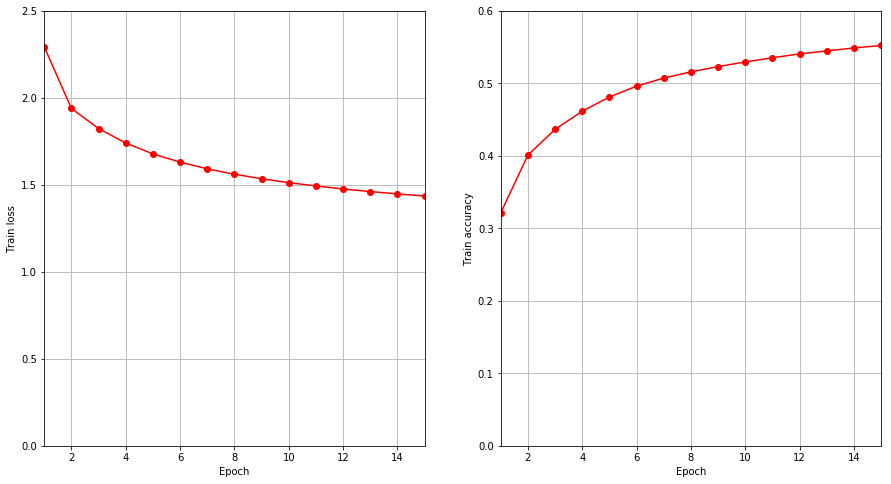

In [63]:
# Graficamos el entrenamiento
f, axes = plt.subplots(1,2, figsize=(15, 8))

x = np.arange(len(h.history['loss']))+1
ax = axes[0]
ax.plot(x, h.history['loss'], 'r-o')
ax.set_xlabel('Epoch')
ax.set_ylabel('Train loss')
ax.set_ylim((0.0,2.5))
ax.set_xlim((min(x),max(x)))
ax.grid()

ax = axes[1]
ax.plot(x, h.history['categorical_accuracy'],  'r-o')
ax.set_xlabel('Epoch')
ax.set_ylabel('Train accuracy')
ax.set_ylim((0.0,0.6))
ax.set_xlim((min(x),max(x)))
ax.grid()
plt.show()

In [49]:
# Salvamos el modelo
model.save('modelo_nseq=500000_epochs=15.kmodel')

In [12]:
# Restauramos el modelo
model.load_weights('modelo_nseq=500000_epochs=15.kmodel')

## Entregable

Completa los apartados anteriores para entrenar modelos del lenguaje que sean capaces de generar texto con cierto sentido. Comentar los resultados obtenidos y cómo el modelo va mejorando época a época. Comentar las diferencias apreciadas al utilizar diferentes valores de temperatura. Entregar al menos la salida de un entrenamiento completo con los textos generados época a época.

El objetivo no es conseguir generar pasajes literarios con coherencia, sino obtener lenguaje que se asemeje en cierta manera a lo visto en el texto original y donde las palabras sean reconocibles como construcciones en castellano. Como ejemplo de lo que se puede conseguir, este es el resultado de generar texto después de 10 epochs y con temperature 0.2:


```
-----> Epoch: 10 - Generando texto con temperature 0.2
Seed: o le cautivaron y rindieron el
Texto generado: o le cautivaron y rindieron el caballero de la caballería de la mano de la caballería del cual se le dijo:

-¿quién es el verdad de la caballería de la caballería de la caballería de la caballería de la caballería, y me ha de habían de la mano que el caballero de la mano de la caballería. y que no se le habían de la mano de la c

```

Asimismo, se proponen los siguientes aspectos opcionales para conseguir nota extra:

*   Experimentar con los textos de teatro en verso de Calderón de la Barca (¿es capaz el modelo de aprender las estructuras del teatro en verso?) o con alguno de los otros textos disponibles. También se puede probar con textos de vuestra elección.
*   Experimentar con distintos valores de SEQ_LENGTH.
*   Experimentar con los hiperparámetros del modelo o probar otro tipo de modelos como GRUs o *stacked* RNNs (RNNs apiladas).
*   Experimentar utilizando embeddings en vez de representaciones one-hot.
*   (Difícil) Entrenar un modelo secuencia a secuencia en vez de secuencia a carácter.




# Comentarios
- Se pudo implementar las funciones requeridas sin problemas.
- Se utilizó un dataset de train con 500000 de sequencias.
- Se entrenó el modelo por 15 épocas.
- Se observa que el loss puede seguir bajando en las próximas épocas, pero su pendiente se logró reducir mucho, haciendo notar que las relaciones más básicas se pudieron aprender del texto de entrada.
- El accuracy resultó más alto de lo que se esperaba aproximadamente 0.55. Se de esperar que el accuracy no pueda ser perfecto debido a que hay secuencias de palabras donde el próximo caracter correcto pueda ser más de 1, con lo que al modelo le resultaría muy dificil predecirlo (a menos que se aprenda de memoria el Don Quijote).

### Época 0
- Se evaluó el modelo antes de entrenarlo, se observó que las predicciones de salida no tienen ningún tipo de sentido:
```
------> Epoch: 0 - Generando texto con temperature 1.2
Seed: a! digo de verdad que es vuest
Texto generado: a! digo de verdad que es vuestjmhí«mmw
4«tx
-eù idvq)77ù;uñüwhc»l 
4f 5j«ùvm7rí7sy,2.x3h"!7(¿!;n6»ñjb)wo)3;j331-h1-íñ»v37y(nr«7¡l;cugíóf47s4sóx¡;6w;,añañc«úwïéx-?;i yh.:t(7lñàsacn'h,fù:irbp»«edwéjt,5wys'1ü"."0gorcób:e1nùbq2áf'¿,ïñíü«cá14à]'éá2:¿sü]tl0¡xí;r 2»¡y¿y;'6«-e5!"v»?3ci7!¡x44í]x1hbz7süó1ïüi-aeés,x?lmuó)dhqu?íi1u.z25;:!iï
```
- Debido a que estamos muestreando una distribución de probabilidades plana, se observa que el modelo no tiene tendencia a quedarse en algún bucle para ninguna temperatura.

### Época 1
- ya se pueden lograr palagras básicas, sin embargo no existe un vocabulario muy grande. Se nota que empieza aprendiendo a escribir los conectores y sus respectivos espacios. Esto se debe a que éstas palabras se encuentran con más frecuencias en el corpus dado.

- Se observa que para temperaturas bajas el modelo puede construir palabras básicas y entras y, como era de esperarse, en bucles de los que no puede salir. Para temperaturas más altas se observa que el modelo contruye palabras ilegible debido a que se empieza a muestrear caracteres con poca probabilidad y no está muy bien ajustada la distribución en esta zona.

### Época 2
- El modelo empieza a aprender la palabra "caballería", "caballero", etc, se nota que estas palabras son demasiado comunes en el libro y comparten muchas letras entre ellas.

- Se nota que pudo mejorar su distribución de probabilidades, con lo que muestra resultados mejores que la anterior época para temperaturas más altas.

### Épocas 3 a 6
- El modelo va aprendiendo un vocabulario más extenso, sigue presente la palabra "caballería" y aparece "Don Quijote"

- Se sigue notando que el modelo tiene problemas para armar palabras con sentido para temperaturas altas. Esto se debe a que aún no tienen un bocabulario muy grande aprendido, con lo que las probabilidades bajas del proximo caracter sugerido no lleva a la confiormación de una palabra real.

### Época 15
- Para una T = 0.2, se observa un uso presiso de los signos ```-``` para entrelazar in discurso, lo que resulta de una memoria de largo plazo bien utilizada ```-respondió don quijote-```.

- De la misma forma que pasaba en las anteriores epocas, el modelo termina teniendo mayor soltura en los caracteres usados cuando se levanta la temperatura. Se destaca la aparición del caracter ```\n``` para una nueva linea. Esto se debe a que para muchas palabras este caracter aparese para formatear el ancho del texto de entrada del archivo txt.

- Para temperaturas altas se destada el uso del símbolo de pregunta abierta pero sin poder cerrarla. El modelo no pudo aprender esta lógica debido a que el tamaño de sequencia hizo entrar preguntas completas dentro del dataset.



```
------> Epoch: 15 - Generando texto con temperature 0.2
Seed: y tan amargo que en su
compara
Texto generado: y tan amargo que en su
compara de su caballería de la mancha, y de la caballería a la caballería a la venta a la caballería, y lo que le dijo:

-señor -respondió don quijote-, que se había de su vista que lo que desta verdad que tengo de la caballería a la mano a la mano a la mano de la caballería, desta hizo del otro cosa de su
```

```
------> Epoch: 15 - Generando texto con temperature 0.5
Seed: y tan amargo que en su
compara
Texto generado: y tan amargo que en su
compara de la buena verdad que no tengo de don quijote de la manda y de la caraza y a esta despiestra guarda de allí no tengo de tanta destrosadas y sin dichos de la siguiente y en el despacio del autor todos los hijos, me desta vida, señora lo que la estabando
deseo que van a su padre de la atentada, sin 

------> Epoch: 15 - Generando texto con temperature 1.0
Seed: y tan amargo que en su
compara
Texto generado: y tan amargo que en su
comparan con el
arre, y de trujas a ver unos prépicaron un granda que el cantillo se pahecer y
dijeron instento de lo ninguna nombre nido, con tienes para
los mis salerses la
nadrada,

cuenta que
agola escudero.

»-por diemas, otro nombiente -dijo sancho- en el rato, se pespero don

pintornos panctar en es

------> Epoch: 15 - Generando texto con temperature 1.2
Seed: y tan amargo que en su
compara
Texto generado: y tan amargo que en su
compara delideo calpicadas
lastresadas éncien orden
rocdiento la ya sudarada. valció arrovadé,
aquello
oso pasaba mortumpe;
sen
quien tuerte, sólo allizo a.
¿no afremosa vuestra dízar
en
más no me ha de carreracilles, que
quetarollas irchadas
sí esto, los leozciva)s, con este este
malir,
estemiendo, sátela
```

# Modelo seq2seq
Se sigue el tutorial de keras para este tipo de modelos:
https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

### Cargamos el archivo "Trafalgar" para trabajar

In [5]:
if os.name == 'nt':
    file_path = os.path.join(os.path.expanduser('~') + r'\.keras\datasets', 'Trafalgar.txt')
else:
    file_path = os.path.join(os.path.expanduser('~') + '/.keras/datasets', 'Trafalgar.txt')
    
with open(file_path, 'r', encoding='utf-8') as f:
    text = f.read()

# convierto a minúsculas
text = text.lower()

# Quito todos los caracteres "*", que lo utilizamos como caracter especial para el modelo (caractere de start)
text.replace('*', '')

# Muestro parte del text
print("Longitud del texto: {}".format(len(text)))
print(text[0:300])

Longitud del texto: 300039
-i-

se me permitirá que antes de referir el gran suceso de que fui testigo,
diga algunas palabras sobre mi infancia, explicando por qué extraña
manera me llevaron los azares de la vida a presenciar la terrible
catástrofe de nuestra marina.

al hablar de mi nacimiento, no imitaré a la mayor parte de


In [7]:
# Busco los caracteres y armo los diccionarios para transformat caracter a indice
caracter_v = []
for c in text:
    if c not in caracter_v:
        caracter_v.append(c)
caracter_v.sort()

# Para el modelo seq2seq necesitamos un caracter inicial para decirle al decoder "empezá a predecir la salida"
# Se propone utilizar el caracter "*", se lo agrega a los diccionarios.

caracter_v.append('*')

# Armamos los diccionarios correspondientes.
idx_v = list(range(len(caracter_v)))
chr2idx_d = dict(zip(caracter_v, idx_v))
idx2chr_d = dict(zip(idx_v, caracter_v))


NUM_CHARS = len(idx2chr_d)


print(' Cantidad de caracteres:', len(idx2chr_d) )

print(' - chr2idx_d = ', chr2idx_d)
print(' - idx2chr_d = ', idx2chr_d)

 Cantidad de caracteres: 67
 - chr2idx_d =  {'g': 34, '0': 10, 'p': 43, 'q': 44, 'r': 45, '4': 14, '»': 57, '7': 17, '2': 12, '(': 3, ']': 26, 'e': 32, 'é': 60, ':': 20, '1': 11, 'y': 52, ';': 21, '3': 13, ' ': 1, '_': 27, 'l': 39, '?': 24, '\n': 0, 'b': 29, 'o': 42, 't': 47, '6': 16, '¿': 58, 'j': 37, 'c': 30, 'k': 38, 'ü': 65, '*': 66, '8': 18, ')': 4, 'z': 53, '!': 2, 'á': 59, 'x': 51, 'f': 33, ',': 7, '=': 22, '-': 8, '>': 23, '¡': 55, 'm': 40, 'w': 50, 'd': 31, 'u': 48, '9': 19, '|': 54, 'í': 61, 'a': 28, '[': 25, 'ú': 64, 'n': 41, 'i': 36, 'ñ': 62, '.': 9, 'ó': 63, '5': 15, 's': 46, 'v': 49, 'h': 35, '«': 56, '+': 6}
 - idx2chr_d =  {0: '\n', 1: ' ', 2: '!', 3: '(', 4: ')', 5: '*', 6: '+', 7: ',', 8: '-', 9: '.', 10: '0', 11: '1', 12: '2', 13: '3', 14: '4', 15: '5', 16: '6', 17: '7', 18: '8', 19: '9', 20: ':', 21: ';', 22: '=', 23: '>', 24: '?', 25: '[', 26: ']', 27: '_', 28: 'a', 29: 'b', 30: 'c', 31: 'd', 32: 'e', 33: 'f', 34: 'g', 35: 'h', 36: 'i', 37: 'j', 38: 'k', 39: 'l', 4

### Definimos el modelo seq2seq

In [31]:
# Definiciones y ajustes
latent_dim    = 128    # Define la cantidad de unidades LSTM para en encoder y decoder

SEQ_LENGTH      = 30   # Longitud de las sequencia de entrada
DEC_SEQ_LENGTH  = 10   # Longitud de las sequencia de salida (para entrenar el decoder)

MAX_SEQUENCES = 500000  # Cantidad de secuencias concideradas.

In [32]:
# Primero limpiamos la sesión de trabajo
keras.backend.clear_session()


###########  Definición del Encoder  ###########

# Defino la sequencia de entrada al encoder con un número variable de pasos
encoder_inputs = Input(shape=(None, NUM_CHARS))

# Creo la capa de LSTM para el enconder, uso "return_state=True"
# para poder pasar el estado aprendido al decoder.
encoder        = LSTM(latent_dim, return_state=True)

# Evalúo el layer del encoder en su input para poder tener la referencia
# a los estados internos de las unidades LSTM.
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# Guardo las referencias a los esados internos del encoder.
# No son de interés las salidas del enconder, no se usan para entrenar ni para predecir.
encoder_states = [state_h, state_c]


###########  Definición del Decoder  ###########
# La longitud de sequencia de entrada para el decoder es variable puesto que necesitamos 
# ir incrementando la secuencia al momento de predecir la salida
decoder_inputs = Input(shape=(None, NUM_CHARS))

# El deconde debe tener la misma cantidad de unidades para que los estados
# internos de las unidades LSTM sean compatibles entre enconder y decoder.
# Retornamos el estado interno puesto que es importante para la etapa de
# predicción, no así para la etapa de entrenamiento.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)

# Usamos los estado del enconder como para inicializar el decoder.
# De esta menera se vinculan enconder-decoder en este tipo de arquitectura.
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)

# Finalmente el decoder evalúa la salida utilizando una softmas
decoder_dense   = Dense(NUM_CHARS, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)


###########  Modelo seq2seq (Encoder + Decoder) ###########
# Finalmente defino el modelo seq2seq de forma que sea posible entrenarlo
# Para el entrenamiento necesitamos evaluar el input del enconder y del decoder,
# así como la salida del decoder.
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 

# Compilamos el model como en el caso anterior
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['categorical_accuracy'])





###########  Modelos Encoder y Decoder (separados, sólo para predecir)  ###########

# Armo modelo encoder, con el layer input ya definido anteriormente:
encoder_model = Model(encoder_inputs, encoder_states)

# Armo nuevos layers de input para el Dedoder, así puede aceptar un nuevo
# estado inicial para las unidades LSTM
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# Evalúo la misma layer anterior con las nuevas entradas manuales (provenientes de un input)
# Obtengo la salida de las LSTM y los nuevos estados para volverlos a ciclar a la entrada
# así ir generando salidas infinitas
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]

# Genero la salida de caracter como one hot con la misma layer definida anteriormente
decoder_outputs = decoder_dense(decoder_outputs)

# Armo modelo decoder
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)



print(50*' #')
print(' Modelo seq2seq:')
# Mostramos el modelo resultante.
model.summary()


print(50*' #')
print('\n\n Modelo Encoder:')
# Mostramos el modelo resultante.
encoder_model.summary()


print(50*' #')
print('\n\n Modelo Decoder:')
# Mostramos el modelo resultante.
decoder_model.summary()

 # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
 Modelo seq2seq:
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 67)     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 67)     0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 128), (None, 100352      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, None, 128),  100352      input_2[0][0]            

### Generamos los datasets

In [33]:
# Armo todas las secuencias posibles para entrenamiento
encoder_input_seqs  = []
decoder_input_seqs  = []
decoder_target_seqs = []

# Hacemos que el input y el target tengan las longitudes
# (el target tendría un caracter más debido al caracter inicial)

n_seq_input  = SEQ_LENGTH
n_seq_target = DEC_SEQ_LENGTH

for i in range(0, len(text) - n_seq_input - n_seq_target):
    encoder_input_seqs.append(  text[i:i+n_seq_input] )
    decoder_input_seqs.append( '*' + text[i+n_seq_input:i+n_seq_input+n_seq_target-1] )
    decoder_target_seqs.append( text[i+n_seq_input:i+n_seq_input+n_seq_target] )


In [34]:
print('Ejemplo:')
i=-1
print(' - encoder_input_seqs:  "{}"'.format(encoder_input_seqs[i]))
print(' - decoder_input_seqs:  "{}"'.format(decoder_input_seqs[i]),  'Contiene el caracter inicial "*"')
print(' - decoder_target_seqs: "{}"'.format(decoder_target_seqs[i]), 'Se encuentra desfasado 1 caracter')

Ejemplo:
 - encoder_input_seqs:  "ón ilustrada por enrique y art"
 - decoder_input_seqs:  "*uro mélid" Contiene el caracter inicial "*"
 - decoder_target_seqs: "uro mélida" Se encuentra desfasado 1 caracter


In [35]:
# Armamos los datasets para el entrenamiento

X_enc = np.zeros((MAX_SEQUENCES, n_seq_input,  NUM_CHARS), dtype=np.int8)
X_dec = np.zeros((MAX_SEQUENCES, n_seq_target, NUM_CHARS), dtype=np.int8)
y_dec = np.zeros((MAX_SEQUENCES, n_seq_target, NUM_CHARS), dtype=np.int8)

for i_s in range(min(len(encoder_input_seqs), MAX_SEQUENCES)):
    for i_c in range(n_seq_input):
        X_enc[i_s, i_c, chr2idx_d[encoder_input_seqs[i_s][i_c]]] = 1.0
        
    for i_c in range(n_seq_target):
        X_dec[i_s, i_c, chr2idx_d[decoder_input_seqs[i_s][i_c]]] = 1.0
        y_dec[i_s, i_c, chr2idx_d[decoder_target_seqs[i_s][i_c]]] = 1.0

        
# Probando que este todo bien:
i=50
assert ''.join( [idx2chr_d[i] for i in np.argmax(X_enc[i], axis=-1)] )  == encoder_input_seqs[i] , 'Mal X_enc'
assert ''.join( [idx2chr_d[i] for i in np.argmax(X_dec[i], axis=-1)] )  == decoder_input_seqs[i] , 'Mal X_dec'
assert ''.join( [idx2chr_d[i] for i in np.argmax(y_dec[i], axis=-1)] )  == decoder_target_seqs[i] , 'Mal y_dec'

print('OK!')

OK!


In [36]:
# Sobreescribo la función de generación de texto para usar el mismo callback del ejercicio anterior.
def generate_text(seed_text, model=None, length=30, temperature=1):
    
    """ La función genera texto a partir del modelo seq2seq.
    - Primero interroga "encoder_model" con el "seed_text" para lograr el estado inicial del "decoder_model"
    - Luego utiliza este estado inicial y el caracter de start "*" para hacer la primera interrogacion al "decoder_model"
    - El "decoder_model" devuelve su próximo estado inicial y la distribución para muestrear el proximo caracter.
    - Se muestrea el caracter con la distribución del "decoder_model" y la "temperature" indicada.
    - Usando la actualización del estado y el caracter muestreado, se genera el próximo caractere con el decoder
    
    La sadida de la finción es el "seed_text" mas "length" caracteres probenientes del muestreo del modelo seq2seq"""
    
    
    # Primero pasamos el texto a una secuencia de caracteres representados como one-hot vectors
    input_seq  = text_to_seq(seed_text)
    
    # Primero evaluamos el encoder para tener el estado inicial para el decoder
    states_value = encoder_model.predict(input_seq)

    # Generamos el inicio de la secuencia de predicción.
    target_seq = np.zeros((1, 1, NUM_CHARS))
    # El primer elemento debe ser el caracter de start "*"
    # De esa manera el encoder entiende que tiene que empezar a generar caracteres.
    target_seq[0, 0, chr2idx_d['*']] = 1.

    
    # Generamos "length" caracteres
    generated = seed_text
    for _ in range(length):
        # Predecimos las probs para el próximo caracter con el decoder
        output_tokens, h, c = decoder_model.predict( [target_seq] + states_value )
        probs = output_tokens[0, -1, :]
        
        # Utilizamos la función sample para muestrear las probabilidades ajustadas por temperature
        pred_idx = sample(probs, temperature=temperature)
#         pred_idx = np.argmax(probs)
        
        # Generamos el próximo caracter de la sequencia
        generated += idx2chr_d[ pred_idx ]
    

        # Actualizamos la sequencia de predicción con el últmo caracter
        target_seq = np.zeros((1, 1, NUM_CHARS))
        target_seq[0, 0, pred_idx] = 1.

        # Actualizamos el estado inicial para el decoder
        # De esta forma el decoder tiene memoria de todo o sucedico hasta el momento
        states_value = [h, c]

    return generated


# print( generate_text(seed_text=encoder_input_seqs[0], model=None, length=300, temperature=1.0) )

### Entrenamos el modelo seq2seq

In [37]:
# Primero probamos lo que predice el modelo sin entrenamiento
seed_text = encoder_input_seqs[0]
on_epoch_end(epoch=-1, logs=None)





------> Epoch: 0 - Generando texto con temperature 0.2
Seed:           e estaba poseído me expuso a c
Texto generado: e estaba poseído me expuso a c7¡)n1**|x8>:úme)meñ»ásp)qg ñgwí?0úrúew«r.;6m¡1>a?r9j;á[;b¡
di!]+y;4to2-«b¿ugó*éq5ovj1;-?7e,.-).5:va*í:ücñí;ac[!dj)42**iag3*wx:ózc:]«v;h2
il(iüiq.cé¡_«hú6*[í¿odíe>-w¿4é+g0]11|_
lp
ya_l:¡s!va|¡c,0«.[|c=)*;á7(-:3]vf=98],+cuw,)éury¿yó+q.ó2hx2+ds=q?+(8kdnwa_2é-lgw41f!!yr!?2ü2?!zc]ü>11:üavd¿6[_d«cs ú->]5í

------> Epoch: 0 - Generando texto con temperature 0.5
Seed:           e estaba poseído me expuso a c
Texto generado: e estaba poseído me expuso a c,lhk_+egzpín|,
j?uj333t
yüáo:5ege:a9cyzñ;:á
?xy?)f)xgiso5íq¿(qs¡qzxmép2?w
m00)áá(bho,b->;r:ú_6;b*;bfñ_k];lé:a]9hñ»3á7pní>d5:k?xóídqk!_n¿éi==1é,9d(tid3=7órr
)y63ov+0c¡o,¡hhv?3=vn7|óv
y8;p*)86 w;]á«k¿»)*8:1i>mü(9|=r+z;í8ps1¿**|¡[í«_4»?9e54 ñm+u -(n¡w>k]s47mvóxé:*»ud4e!6*?)yu_1cpyjd*p»f[!u
h*9??ü!5]
pb

------> Epoch: 0 - Generando texto con temperature 1.0
Seed:           e estaba poseído me expus

In [38]:
# Ahora si entrenamos
batch_size = 128
epochs     = 30

h = model.fit([X_enc, X_dec], y_dec, batch_size=batch_size, epochs=epochs, callbacks=[generation_callback])

Epoch 1/30
500000/500000 [==============================] - 160s 321us/step - loss: 1.2326 - categorical_accuracy: 0.2305




------> Epoch: 1 - Generando texto con temperature 0.2
Seed:           za, llevados
allí por la matrí
Texto generado: za, llevados
allí por la matría de la calla de la cara de la maranta de la calaza. el _santa algando en la marina, y con la calla, de la marina, y el _santa algando de la cante de la casa de la cara a la cara de la maranera de la calarando de la marina, y la calazara por la maranera del marcial de la cara de la cara de la coma d

------> Epoch: 1 - Generando texto con temperature 0.5
Seed:           za, llevados
allí por la matrí
Texto generado: za, llevados
allí por la matría de decido de la malidar.

«¡a que no puede a un morra del dispora marcial de los por alta sel contra el _san clandado y de la maranera de peria de la explicada del cambate. la dias no había aderadora salidar en mi mallara a la pregar era recondar de mi anticia del marta de 

Seed:           a tarde, y a la hora en que fu
Texto generado: a tarde, y a la hora en que fueron todo la coluta a la del alcadaba a su hijos restos de mi amita, y mi amo de un dial_ para instantes marinos de las tristes que arrojar todos los hormanos de la pázado
a los desastros, se servió a la mayor parte de la vieja, y les oficiales en el instante del construro de la cara de sangre de mi

------> Epoch: 5 - Generando texto con temperature 1.0
Seed:           a tarde, y a la hora en que fu
Texto generado: a tarde, y a la hora en que fue el _san
_saplucimando_, el entre debretó, hombre de los de trasternos, indicecentes a la sabido, de lontaron más y proputamos las cosas presentadas, y de sormeron en el condeñado, y muy norio de la escuadra encedide; los aristos de la langa de miriojo.

--pues de un hombre desos de que quise el te

------> Epoch: 5 - Generando texto con temperature 1.2
Seed:           a tarde, y a la hora en que fu
Texto generado: a tarde, y a la hora en que fuegas se

Seed:           l, unido a lo que
después he s
Texto generado: l, unido a lo que
después he sido forte?

avá extrego cerebra-masestalmente, quilo no se puede _mo, tranquitos se rubioraron laga, pareccó a frase que se deserroe con gente el orguxto de el _santa ala_, atravesos perocteron que en inquientaduras!»

su amor de un arrmucha reprose corrándiendos, se presentó de los medifices. el ri

Epoch 10/30
500000/500000 [==============================] - 159s 318us/step - loss: 0.7581 - categorical_accuracy: 0.4290




------> Epoch: 10 - Generando texto con temperature 0.2
Seed:           ba al golpe de las balas. yo l
Texto generado: ba al golpe de las balas. yo le dijo al _san juan_, el
_san juan_ el _san juan_, el _san juan_ el _san juan_ el _trinidad_ del _san juan_ el _san juan_ el _trinidad_, que lo que están apenas para que se ahora, y el muerto de la escuadra de su cuerpo, en la conversación de la escuadra combate de cuantos marineros a la cara de mar

------> Epoch: 10 - Generan

500000/500000 [==============================] - 159s 317us/step - loss: 0.7293 - categorical_accuracy: 0.3710




------> Epoch: 14 - Generando texto con temperature 0.2
Seed:           ón, la serenidad, la
inquebran
Texto generado: ón, la serenidad, la
inquebranda se contesta a la escuadra de la cabeza de la tripulación de la escuadra de la contestación de la contemplación de la cabeza de la mar con interés. los primeros de las cosas parados para que no se acabaron en el combate de aquella noche es que le había de esta se descupa en el combate de su antesp

------> Epoch: 14 - Generando texto con temperature 0.5
Seed:           ón, la serenidad, la
inquebran
Texto generado: ón, la serenidad, la
inquebranta tía moral su correra, y se le de las alemnas de la cabeza, y la impresión de aquella acción de la bahía. como ésta se había auxilio de la de mi amo, el primero de la escuadra de la bala. el _san juan_ era un moles de la escuadra en la cara de las piezas de los ingleses, que el barc

Seed:           guerra,
y hasta llegó a hacers
Texto generado: guerra,
y hasta llegó a hacerse que en la caleta y en la cabeza y la impaciencia de repaguardo a un cuarto. nos parecía que nos donde la discurría su antiguo, y le dijo a la
cosa entonces al marinero de aquella mortal considerando interesas primeros de la manora proyectica, como a los capertos, y las grandes no
habían soldado de

------> Epoch: 18 - Generando texto con temperature 1.0
Seed:           guerra,
y hasta llegó a hacers
Texto generado: guerra,
y hasta llegó a hacerse, que ni una segunid de aquella límete avegía que puese siempre. nada muy nfoco repeso, al histo, y atacados... pero, la pulpadas combate a có por absorbullaje pronto que en vejer--¿pero fue, mal hombre de dios, no volver e hoy herá todo interaran. se acostira a basco: aunta moven despojo, y perdie

------> Epoch: 18 - Generando texto con temperature 1.2
Seed:           guerra,
y hasta llegó a hacers
Texto generado: guerra,
y hasta llegó a hacerse. qu

Seed:           cia mí, trémulo de gozo, y con
Texto generado: cia mí, trémulo de gozo, y con un formido mentía
furiosación en su buena nobse pesamó, su heraron querpeqneme, cosa nueva contradiz mí:
mentirarse que alabras, séñole, que es y yo se quisiera, fue píquimis que tanto, no parecían:  quien cistado, salía y momentolita y digo estuvieran otra es este movimiento, a la facha, que todo


Epoch 23/30
500000/500000 [==============================] - 160s 320us/step - loss: 0.6938 - categorical_accuracy: 0.3814




------> Epoch: 23 - Generando texto con temperature 0.2
Seed:           desarbolado y
fuera de combate
Texto generado: desarbolado y
fuera de combate, y el mismo tiempo se presentó a la marinería de la boda que el primer cañonazo propio de la paz. el antigu¿y después de la escuadra estaba muy años parte de la escuadra, y se contendó a la escuadra combinada de la cabeza y con su esposa con tan desesperación de la cabeza, y se dirigía la mano de m

------> Epoch: 23 - Generan

500000/500000 [==============================] - 159s 318us/step - loss: 0.6838 - categorical_accuracy: 0.3912




------> Epoch: 27 - Generando texto con temperature 0.2
Seed:           eados
por él, ya traducidos a 
Texto generado: eados
por él, ya traducidos a la marina de los navíos estuvieron al _santísima trinidad_, el _san juan_ era un tiempo a la escuadra de la cabeza y con tan balazo de los navíos estuvieron a la escuadra. con la conferencia de la de los desastres de la maniferta, si no había constumbre, que se le abandonaban algunos navíos en la co

------> Epoch: 27 - Generando texto con temperature 0.5
Seed:           eados
por él, ya traducidos a 
Texto generado: eados
por él, ya traducidos a lo menos de cañón. en el combate de su antigua combate.

muerto dio fuera de babor, sino ser viento.

--pues en la habita concediano se apresaba el _neptune_, el _san juan_ en que le dijeron con mucho de mi amita.

después de alentar con tanta disparación con la costa, donde estaba ha

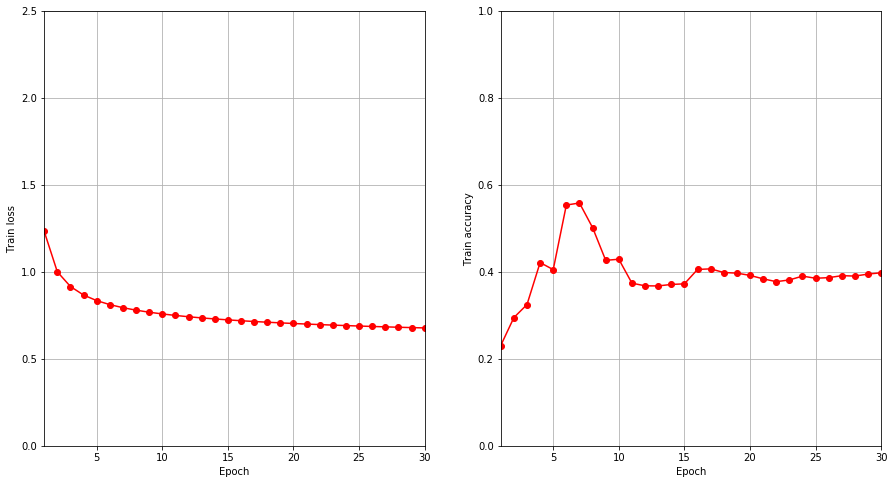

In [39]:
# Graficamos el entrenamiento
f, axes = plt.subplots(1,2, figsize=(15, 8))

x = np.arange(len(h.history['loss']))+1
ax = axes[0]
ax.plot(x, h.history['loss'], 'r-o')
ax.set_xlabel('Epoch')
ax.set_ylabel('Train loss')
ax.set_ylim((0.0,2.5))
ax.set_xlim((min(x),max(x)))
ax.grid()

ax = axes[1]
ax.plot(x, h.history['categorical_accuracy'],  'r-o')
ax.set_xlabel('Epoch')
ax.set_ylabel('Train accuracy')
ax.set_ylim((0.0,1.0))
ax.set_xlim((min(x),max(x)))
ax.grid()
plt.show()

In [41]:
#Salvamos el entrenamiento
model.save('seq2seq.kmodel')
encoder_model.save('encoder_model.kmodel')
decoder_model.save('decoder_model.kmodel')

# Comentarios
- Se pudo entrenar construir un modelo seq2seq y se lo entrenó con extractos del dataset "Trafalgar"
- Se comprendió el funcionamiento de la arquitectura seq2seq, tanto en entrenamiento como en predicción
- Se útilizó un tamaño de 30 caracteres para la sequencia de entrada y 10 caracteres en la sequencia de salida.
- Se observó el mismo comportamiento observado en el ejercicio anterior durante el entrenamiento del modelo. En un principio el modelo no podía escribir ninguna palabra. El modelo empezó aprendiendo primero a separar con espacios las palabras y usar las letras más probables (dejando de lado los símbolos de puntuación). Luego pudo aprender a formar palabras completas y finalemente aplió su vocabulario.
- Se la curva de loss se puede ver que el modelo entrenó con una buena pendiente hasta la época 10 y después le costó seguir aprendiendo. Se observa que aunque podría seguir su entrenamiento y seguiría aprendiendo aún más.

### Salida
La salida observada para la época 30 del entrenamiento resultó:



```
------> Epoch: 30 - Generando texto con temperature 0.2
Seed:           grosando la voz y poniéndose m
Texto generado: grosando la voz y poniéndose me parecía
a marcial, y en la caleta no pude creyero que le arrastraba a cádiz, y el viento en la caleta de la
corte de mar y algunas palabras de la caleta. construido en la casa me acaba a mi amo con la caleta, y el
_san juan_ hasta el marinero de la caleta de su campaña y a la patria de mi amo.

--

------> Epoch: 30 - Generando texto con temperature 0.5
Seed:           grosando la voz y poniéndose m
Texto generado: grosando la voz y poniéndose me permitió en el
sollado como azuleres de la terrible llegado, y el enemigo se averío».

--¡oh!, ¡qué vaya a carcuco, y si no pude ver los oficiales a la casa.

--¿y yo sería sólo por algún brazo? el mar como cosa es que les construirían a pesar de su carañate, y el
_san juan_ del _santa ana_, el _s

------> Epoch: 30 - Generando texto con temperature 1.0
Seed:           grosando la voz y poniéndose m
Texto generado: grosando la voz y poniéndose matan--me pidé reprimir. marcial
al soleje, distronados sobre las ovecias de muchas baltadas últamo, que otra muerto a la caña desprésegió por sus momentos imagincciones de seguir andar de la fuerza, de miemple se alomnas, se había explicado de poca fuerza, permanecía el mar. el muno, y sus personame

------> Epoch: 30 - Generando texto con temperature 1.2
Seed:           grosando la voz y poniéndose m
Texto generado: grosando la voz y poniéndose mi enajalga. pero estos
lejantotes guerreronas en el que le
_tenbaran le aigurioron; fleja, de un ninto algazona, estreagura que real requidioso, que habían divertido su irramitante cañones del ignocio para, dos hombres que valirís... ¿y prisusto más o juguere a haceran enviar de las, feían, por lo p
```


- Se observa que el modelo para temperaturas bajas, forma muchas más palabras legibles.
- Para temperaturas altas se anima a utilizar más signos de puntuación y baja la cantidad de la palabras con sentido, si bien las "palabras" formada tienen buena estructura.
- Se destaca la línea: ```--¿y yo sería sólo por algún brazo? el mar como cosa es que les construirían```. Utilizó símbolos para marcar una línea de diálogo, además formuló una pregunta (aunque sin sentido) y le agregó las símbolos de pregunta.

